In [1]:
import pandas as pd
import numpy as np 
import sklearn
from sklearn import linear_model
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
from pycaret.regression import setup,compare_models
import scipy.stats as stats
from sklearn.ensemble import ExtraTreesRegressor

from sklearn.ensemble import ExtraTreesRegressor, RandomForestRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.svm import SVR
from sklearn.model_selection import train_test_split

## The parts that needs to be completed today
1. Data Preprocessing (Filling in the Null Values, Right Data Types)
2. Feature Engineering [Not really needed for columns less that 300]  
3. Feature Transformation 
4. Encoding [For categorical variables]
5. Scaling

6. Target Trasformation [Making it into log, for better predictions]
7. Model Selection 
Baseline --> Submision (Best Model)

8. Hyperparameter Optimization 
9. Ensembling [Most Important]
10. Feature Selection

## Loading the Data

In [3]:
train_data_0  = pd.read_csv('dengue_features_train.csv')
test_data_0 = pd.read_csv('dengue_features_test.csv')

labels_train = pd.read_csv('dengue_labels_train.csv')
sub_format = pd.read_csv('submission_format.csv')

### Getting the general feel of the data

In [4]:
print("train data shape: ",train_data_0.shape) 
print("test data shape:  ", test_data_0.shape)
print('labels_train shape: ',labels_train.shape)

print(train_data_0.columns)
print(labels_train.columns)

train data shape:  (1456, 24)
test data shape:   (416, 24)
labels_train shape:  (1456, 4)
Index(['city', 'year', 'weekofyear', 'week_start_date', 'ndvi_ne', 'ndvi_nw',
       'ndvi_se', 'ndvi_sw', 'precipitation_amt_mm', 'reanalysis_air_temp_k',
       'reanalysis_avg_temp_k', 'reanalysis_dew_point_temp_k',
       'reanalysis_max_air_temp_k', 'reanalysis_min_air_temp_k',
       'reanalysis_precip_amt_kg_per_m2',
       'reanalysis_relative_humidity_percent', 'reanalysis_sat_precip_amt_mm',
       'reanalysis_specific_humidity_g_per_kg', 'reanalysis_tdtr_k',
       'station_avg_temp_c', 'station_diur_temp_rng_c', 'station_max_temp_c',
       'station_min_temp_c', 'station_precip_mm'],
      dtype='object')
Index(['city', 'year', 'weekofyear', 'total_cases'], dtype='object')


## Data Output

In [5]:
print(train_data_0.head(3))
print(labels_train.head(3))

  city  year  weekofyear week_start_date  ndvi_ne   ndvi_nw   ndvi_se  \
0   sj  1990          18      1990-04-30  0.12260  0.103725  0.198483   
1   sj  1990          19      1990-05-07  0.16990  0.142175  0.162357   
2   sj  1990          20      1990-05-14  0.03225  0.172967  0.157200   

    ndvi_sw  precipitation_amt_mm  reanalysis_air_temp_k  ...  \
0  0.177617                 12.42             297.572857  ...   
1  0.155486                 22.82             298.211429  ...   
2  0.170843                 34.54             298.781429  ...   

   reanalysis_precip_amt_kg_per_m2  reanalysis_relative_humidity_percent  \
0                            32.00                             73.365714   
1                            17.94                             77.368571   
2                            26.10                             82.052857   

   reanalysis_sat_precip_amt_mm  reanalysis_specific_humidity_g_per_kg  \
0                         12.42                              14.012

## Cleaning the Data

In [6]:
## Finding the Null Values
data_1 = train_data_0.copy()

print(data_1.isna().sum().sort_values(ascending=False))

data_1['week_start_date']

## Percentage of missing values
for i in data_1.isna().sum().sort_values(ascending=False):
    print(i/(data_1.shape[0]))

ndvi_ne                                  194
ndvi_nw                                   52
station_diur_temp_rng_c                   43
station_avg_temp_c                        43
station_precip_mm                         22
ndvi_se                                   22
ndvi_sw                                   22
station_max_temp_c                        20
station_min_temp_c                        14
precipitation_amt_mm                      13
reanalysis_sat_precip_amt_mm              13
reanalysis_relative_humidity_percent      10
reanalysis_tdtr_k                         10
reanalysis_specific_humidity_g_per_kg     10
reanalysis_max_air_temp_k                 10
reanalysis_precip_amt_kg_per_m2           10
reanalysis_min_air_temp_k                 10
reanalysis_dew_point_temp_k               10
reanalysis_avg_temp_k                     10
reanalysis_air_temp_k                     10
year                                       0
week_start_date                            0
weekofyear

In [7]:
print(data_1['week_start_date'].head(3))

0    1990-04-30
1    1990-05-07
2    1990-05-14
Name: week_start_date, dtype: object


In [8]:
## Combining train & test data for the better interpolation of missing numerical values
data_2 = data_1.copy()

data_2 = pd.concat([data_2,test_data_0],axis=0)
## data_2 now contains the combination of train and test dataset

In [9]:
np.mean(data_2.loc[data_2["ndvi_ne"].isna() == False,"ndvi_ne"])

0.13858777150256885

In [10]:
data_3 = data_2.copy()
## The name of columns, in which there are missing values. 
## Find the rows, which do not have the 
na_cols = data_2.loc[:,data_2.isna().sum() > 0].columns

for i in na_cols: 
    mean = np.mean(data_2.loc[data_2[i].isna() == False,i])
    data_3.loc[data_3[i].isna() == True,i] = mean

In [11]:
data_3.isna().sum()
## The data is now cleaned, and there are no null values

city                                     0
year                                     0
weekofyear                               0
week_start_date                          0
ndvi_ne                                  0
ndvi_nw                                  0
ndvi_se                                  0
ndvi_sw                                  0
precipitation_amt_mm                     0
reanalysis_air_temp_k                    0
reanalysis_avg_temp_k                    0
reanalysis_dew_point_temp_k              0
reanalysis_max_air_temp_k                0
reanalysis_min_air_temp_k                0
reanalysis_precip_amt_kg_per_m2          0
reanalysis_relative_humidity_percent     0
reanalysis_sat_precip_amt_mm             0
reanalysis_specific_humidity_g_per_kg    0
reanalysis_tdtr_k                        0
station_avg_temp_c                       0
station_diur_temp_rng_c                  0
station_max_temp_c                       0
station_min_temp_c                       0
station_pre

## Encoding the Categorical Variables: 


In [12]:
data_4 = data_3.copy()
data_4['week_start_date'] = pd.to_datetime(data_4['week_start_date'], 
 format = "%Y-%m-%d",
 errors = "coerce")

li = LabelEncoder()
data_4["city"]=li.fit_transform(data_4["city"])


In [13]:
data_5 = data_4.copy()

data_5["year"] = data_5["week_start_date"].dt.year
# data_5["week"] = data_5["week_start_date"].dt.isocalendar().week
data_5["day"] = data_5["week_start_date"].dt.day

data_5 = data_5.drop(columns="week_start_date",axis=1)

In [14]:
data_5.head(5)

,city,year,weekofyear,ndvi_ne,ndvi_nw,ndvi_se,ndvi_sw,precipitation_amt_mm,reanalysis_air_temp_k,reanalysis_avg_temp_k,...,reanalysis_relative_humidity_percent,reanalysis_sat_precip_amt_mm,reanalysis_specific_humidity_g_per_kg,reanalysis_tdtr_k,station_avg_temp_c,station_diur_temp_rng_c,station_max_temp_c,station_min_temp_c,station_precip_mm,day
0,1,1990,18,0.122600,0.103725,0.198483,0.177617,12.42,297.572857,297.742857,...,73.365714,12.42,14.012857,2.628571,25.442857,6.900000,29.4,20.0,16.0,30
1,1,1990,19,0.169900,0.142175,0.162357,0.155486,22.82,298.211429,298.442857,...,77.368571,22.82,15.372857,2.371429,26.714286,6.371429,31.7,22.2,8.6,7
2,1,1990,20,0.032250,0.172967,0.157200,0.170843,34.54,298.781429,298.878571,...,82.052857,34.54,16.848571,2.300000,26.714286,6.485714,32.2,22.8,41.4,14
3,1,1990,21,0.128633,0.245067,0.227557,0.235886,15.36,298.987143,299.228571,...,80.337143,15.36,16.672857,2.428571,27.471429,6.771429,33.3,23.3,4.0,21
4,1,1990,22,0.196200,0.262200,0.251200,0.247340,7.52,299.518571,299.664286,...,80.460000,7.52,17.210000,3.014286,28.942857,9.371429,35.0,23.9,5.8,28


### Skewness of the data, and making it more normally distributed

In [15]:
skw_cols = []
skw_vals = []
for i in data_5.select_dtypes(np.number).columns:
    if(abs(stats.skew(data_5[i]))>0.5):
        print(f'Name: {i} \t Skew: {stats.skew(data_5[i])}')
        skw_cols.append(i)
        skw_vals.append(stats.skew(data_5[i]))

del(skw_cols[0:3])
del(skw_vals[0:3])
print(skw_cols)
print(skw_vals)

Name: city 	 Skew: -0.5783149319662401
Name: ndvi_se 	 Skew: 0.5307665783038413
Name: ndvi_sw 	 Skew: 0.7424829766789421
Name: precipitation_amt_mm 	 Skew: 1.6861214143567895
Name: reanalysis_dew_point_temp_k 	 Skew: -0.7065322303045248
Name: reanalysis_max_air_temp_k 	 Skew: 0.8174446958523416
Name: reanalysis_min_air_temp_k 	 Skew: -0.6298707446195395
Name: reanalysis_precip_amt_kg_per_m2 	 Skew: 3.1018451073817026
Name: reanalysis_relative_humidity_percent 	 Skew: 0.5655967700814637
Name: reanalysis_sat_precip_amt_mm 	 Skew: 1.6861214143567895
Name: reanalysis_specific_humidity_g_per_kg 	 Skew: -0.537707807360374
Name: reanalysis_tdtr_k 	 Skew: 1.0303342573772374
Name: station_avg_temp_c 	 Skew: -0.511583426408439
Name: station_diur_temp_rng_c 	 Skew: 0.8352994420377833
Name: station_precip_mm 	 Skew: 2.9788042270747974
['precipitation_amt_mm', 'reanalysis_dew_point_temp_k', 'reanalysis_max_air_temp_k', 'reanalysis_min_air_temp_k', 'reanalysis_precip_amt_kg_per_m2', 'reanalysis_rela

In [16]:
data_5[skw_cols].describe()
zero_cols = ["precipitation_amt_mm","reanalysis_precip_amt_kg_per_m2","reanalysis_sat_precip_amt_mm",
             "station_precip_mm"]
non_zero_cols = [col for col in skw_cols if col not in zero_cols]

Using the log trasform to make the data more normal

In [17]:
skw_df = pd.DataFrame()
skw_df['Columns'],skw_df['Values'] = pd.DataFrame(skw_cols),pd.DataFrame(skw_vals) 
skw_df

,Columns,Values
0,precipitation_amt_mm,1.686121
1,reanalysis_dew_point_temp_k,-0.706532
2,reanalysis_max_air_temp_k,0.817445
3,reanalysis_min_air_temp_k,-0.629871
4,reanalysis_precip_amt_kg_per_m2,3.101845
5,reanalysis_relative_humidity_percent,0.565597
6,reanalysis_sat_precip_amt_mm,1.686121
7,reanalysis_specific_humidity_g_per_kg,-0.537708
8,reanalysis_tdtr_k,1.030334
9,station_avg_temp_c,-0.511583


In [18]:
skw_df["abs"] = skw_df["Values"].apply(lambda cols: abs(cols))
skw_df["adj_skw"] = skw_df["abs"].apply(lambda cols: np.log1p(cols))
skw_df["Normally"] = skw_df["adj_skw"].apply(lambda cols: 'Yes' if(cols < 0.6) else 'No')
skw_df

,Columns,Values,abs,adj_skw,Normally
0,precipitation_amt_mm,1.686121,1.686121,0.988098,No
1,reanalysis_dew_point_temp_k,-0.706532,0.706532,0.534463,Yes
2,reanalysis_max_air_temp_k,0.817445,0.817445,0.597432,Yes
3,reanalysis_min_air_temp_k,-0.629871,0.629871,0.488501,Yes
4,reanalysis_precip_amt_kg_per_m2,3.101845,3.101845,1.411437,No
5,reanalysis_relative_humidity_percent,0.565597,0.565597,0.448267,Yes
6,reanalysis_sat_precip_amt_mm,1.686121,1.686121,0.988098,No
7,reanalysis_specific_humidity_g_per_kg,-0.537708,0.537708,0.430293,Yes
8,reanalysis_tdtr_k,1.030334,1.030334,0.708200,No
9,station_avg_temp_c,-0.511583,0.511583,0.413158,Yes


In [19]:
###Applying the log transform in dataframe: 
a1 = 0
a2 = 0
data_6 = data_5.copy()
for i in skw_df['Columns']:
    bc = stats.skew(data_6[i])
    print(f'Before: {bc} skeness for {i}')
    if(i in zero_cols):
        data_6[i] = np.log1p(data_6[i]) 
    else: 
        data_6[i] = np.log(data_6[i]) 
    print(f'After:{stats.skew(data_6[i])} skeness for {i} \n')

n_ele = skw_df['Columns'].shape[0]
print(f"Before: {a1} ({({a1/n_ele})}) After: {a2} ({a2/n_ele}) Total: {n_ele}")

Before: 1.6861214143567895 skeness for precipitation_amt_mm
After:-0.9452553419521534 skeness for precipitation_amt_mm 

Before: -0.7065322303045248 skeness for reanalysis_dew_point_temp_k
After:-0.7170449527327287 skeness for reanalysis_dew_point_temp_k 

Before: 0.8174446958523416 skeness for reanalysis_max_air_temp_k
After:0.7996503592880456 skeness for reanalysis_max_air_temp_k 

Before: -0.6298707446195395 skeness for reanalysis_min_air_temp_k
After:-0.6472253462674077 skeness for reanalysis_min_air_temp_k 

Before: 3.1018451073817026 skeness for reanalysis_precip_amt_kg_per_m2
After:-0.44467994602685645 skeness for reanalysis_precip_amt_kg_per_m2 

Before: 0.5655967700814637 skeness for reanalysis_relative_humidity_percent
After:0.39194762310757053 skeness for reanalysis_relative_humidity_percent 

Before: 1.6861214143567895 skeness for reanalysis_sat_precip_amt_mm
After:-0.9452553419521534 skeness for reanalysis_sat_precip_amt_mm 

Before: -0.537707807360374 skeness for reanalys

In [20]:
stats.skew(data_6)

array([-0.57831493, -0.39523689,  0.00143842, -0.16074205,  0.11900638,
        0.53076658,  0.74248298, -0.94525534, -0.05962278, -0.17682459,
       -0.71704495,  0.79965036, -0.64722535, -0.44467995,  0.39194762,
       -0.94525534, -0.71948773,  0.57929467, -0.62947065,  0.44389091,
       -0.2681017 , -0.26641419, -0.5541623 ,  0.00928823])

In [21]:
data_7 = data_6.copy()
## Scaling the Data: 
scaler = StandardScaler()
data_7 = scaler.fit_transform(data_6)
data_7 = pd.DataFrame(data_7,columns=data_6.columns)

In [22]:
data_7.head(5)

,city,year,weekofyear,ndvi_ne,ndvi_nw,ndvi_se,ndvi_sw,precipitation_amt_mm,reanalysis_air_temp_k,reanalysis_avg_temp_k,...,reanalysis_relative_humidity_percent,reanalysis_sat_precip_amt_mm,reanalysis_specific_humidity_g_per_kg,reanalysis_tdtr_k,station_avg_temp_c,station_diur_temp_rng_c,station_max_temp_c,station_min_temp_c,station_precip_mm,day
0,0.751809,-2.097575,-0.565867,-0.116878,-0.211414,-0.082854,-0.288179,-0.296174,-0.835330,-1.191639,...,-1.287228,-0.296174,-1.855101,-0.625660,-1.417779,-0.444651,-1.584567,-1.348008,-0.180823,1.680797
1,0.751809,-2.097575,-0.499211,0.228908,0.101378,-0.567241,-0.547883,0.067315,-0.373461,-0.639625,...,-0.667991,0.067315,-0.879878,-0.783857,-0.380742,-0.754697,-0.397739,0.024461,-0.641801,-0.946482
2,0.751809,-2.097575,-0.432554,-0.777381,0.351869,-0.636388,-0.367669,0.320799,0.038810,-0.296025,...,0.017211,0.320799,0.085178,-0.830853,-0.380742,-0.685535,-0.139733,0.398771,0.556429,-0.146875
3,0.751809,-2.097575,-0.365898,-0.072772,0.938404,0.306972,0.395598,-0.170682,0.187600,-0.020018,...,-0.229108,-0.170682,-0.025200,-0.747268,0.213621,-0.517824,0.427880,0.710696,-1.168018,0.652731
4,0.751809,-2.097575,-0.299242,0.421173,1.077783,0.623980,0.530012,-0.583991,0.571973,0.323583,...,-0.211296,-0.583991,0.308639,-0.415257,1.323252,0.746335,1.305100,1.085006,-0.919977,1.452338


### Target Tranformation

<Axes: >

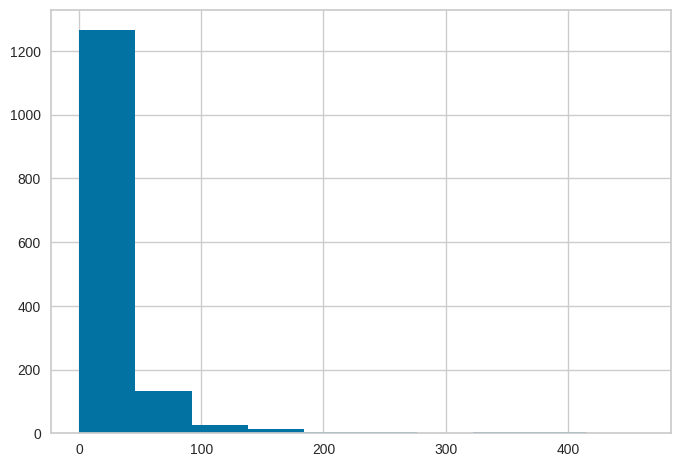

In [23]:
labels_train["total_cases"].hist()

<Axes: >

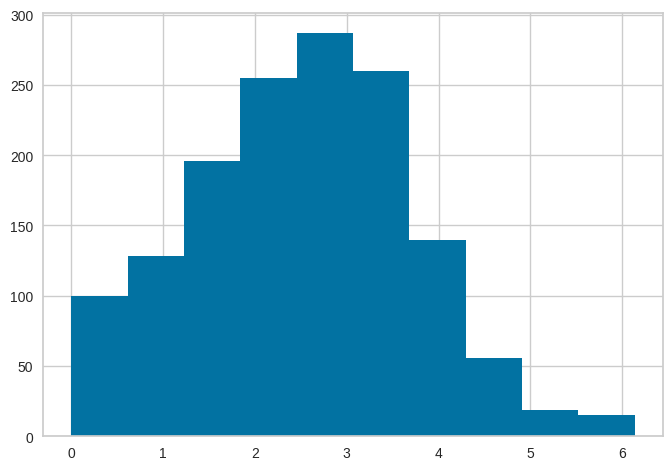

In [24]:
log_target = np.log1p(labels_train["total_cases"])
# labels_train["total_cases"].describe()
stats.skew(log_target)
log_target.hist()

### Splitting the data back

In [51]:
train_rows = train_data_0.shape[0]

train_processed = data_7.iloc[:train_rows,:]
test_processed = data_7.iloc[train_rows:,:].reset_index()
test_processed = test_processed.drop(['index'],axis=1)

In [52]:
train_data_0
test_data_0

,city,year,weekofyear,week_start_date,ndvi_ne,ndvi_nw,ndvi_se,ndvi_sw,precipitation_amt_mm,reanalysis_air_temp_k,...,reanalysis_precip_amt_kg_per_m2,reanalysis_relative_humidity_percent,reanalysis_sat_precip_amt_mm,reanalysis_specific_humidity_g_per_kg,reanalysis_tdtr_k,station_avg_temp_c,station_diur_temp_rng_c,station_max_temp_c,station_min_temp_c,station_precip_mm
0,sj,2008,18,2008-04-29,-0.018900,-0.018900,0.102729,0.091200,78.60,298.492857,...,25.37,78.781429,78.60,15.918571,3.128571,26.528571,7.057143,33.3,21.7,75.2
1,sj,2008,19,2008-05-06,-0.018000,-0.012400,0.082043,0.072314,12.56,298.475714,...,21.83,78.230000,12.56,15.791429,2.571429,26.071429,5.557143,30.0,22.2,34.3
2,sj,2008,20,2008-05-13,-0.001500,NaN,0.151083,0.091529,3.66,299.455714,...,4.12,78.270000,3.66,16.674286,4.428571,27.928571,7.785714,32.8,22.8,3.0
3,sj,2008,21,2008-05-20,NaN,-0.019867,0.124329,0.125686,0.00,299.690000,...,2.20,73.015714,0.00,15.775714,4.342857,28.057143,6.271429,33.3,24.4,0.3
4,sj,2008,22,2008-05-27,0.056800,0.039833,0.062267,0.075914,0.76,299.780000,...,4.36,74.084286,0.76,16.137143,3.542857,27.614286,7.085714,33.3,23.3,84.1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
411,iq,2013,22,2013-05-28,0.301471,0.380029,0.280629,0.383186,41.12,297.774286,...,67.60,89.990000,41.12,17.185714,10.100000,27.400000,9.050000,32.6,21.8,33.0
412,iq,2013,23,2013-06-04,0.247600,0.296343,0.285371,0.350357,71.52,297.167143,...,45.70,93.891429,71.52,17.448571,9.657143,27.520000,10.720000,33.8,21.4,68.0
413,iq,2013,24,2013-06-11,0.238729,0.251029,0.252586,0.249771,78.96,295.831429,...,45.22,94.967143,78.96,16.410000,7.385714,27.200000,10.075000,32.6,21.6,93.2
414,iq,2013,25,2013-06-18,0.310429,0.302700,0.406614,0.403943,39.54,295.778571,...,4.70,89.057143,39.54,15.137143,8.228571,26.700000,8.480000,32.2,21.8,34.1


In [53]:
test_processed

,city,year,weekofyear,ndvi_ne,ndvi_nw,ndvi_se,ndvi_sw,precipitation_amt_mm,reanalysis_air_temp_k,reanalysis_avg_temp_k,...,reanalysis_relative_humidity_percent,reanalysis_sat_precip_amt_mm,reanalysis_specific_humidity_g_per_kg,reanalysis_tdtr_k,station_avg_temp_c,station_diur_temp_rng_c,station_max_temp_c,station_min_temp_c,station_precip_mm,day
0,0.751809,0.763843,-0.565867,-1.151312e+00,-1.208971e+00,-1.366750,-1.302265,0.831625,-0.169909,-0.555133,...,-0.457048,0.831625,-0.512617,-0.358072,-0.529102,-0.357046,0.427880,-0.287464,1.029315,1.566567
1,0.751809,0.763843,-0.499211,-1.144733e+00,-1.156093e+00,-1.644108,-1.523886,-0.289599,-0.182308,-0.549501,...,-0.538924,-0.289599,-0.597045,-0.659435,-0.898766,-1.286652,-1.274960,0.024461,0.408593,-1.060711
2,0.751809,0.763843,-0.432554,-1.024110e+00,-2.257922e-16,-0.718402,-1.298409,-0.966245,0.526510,0.081373,...,-0.532965,-0.966245,-0.024298,0.175918,0.564600,0.025175,0.169874,0.398771,-1.348024,-0.261105
3,0.751809,0.763843,-0.365898,4.058135e-16,-1.216835e+00,-1.077133,-0.897581,-1.941210,0.695965,0.374278,...,-1.342969,-1.941210,-0.607528,0.145885,0.662279,-0.816239,0.427880,1.396931,-2.254675,0.538502
4,0.751809,0.763843,-0.299242,-5.979083e-01,-7.311740e-01,-1.909270,-1.481640,-1.583084,0.761060,0.329216,...,-1.173615,-1.583084,-0.369040,-0.166978,0.323925,-0.341328,0.427880,0.710696,1.118426,1.338108
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
411,-1.330124,1.558681,-0.299242,1.190758e+00,2.036321e+00,1.018564,2.124139,0.428408,-0.689640,-0.228431,...,1.093510,0.428408,0.293772,1.442832,0.158253,0.610561,0.066671,-0.225079,0.378324,1.452338
412,-1.330124,1.558681,-0.232585,7.969323e-01,1.355537e+00,1.082156,1.738901,0.772613,-1.128776,-0.729750,...,1.588216,0.772613,0.453585,1.373932,0.251188,1.269365,0.685886,-0.474618,0.949249,-1.289170
413,-1.330124,1.558681,-0.165929,7.320781e-01,9.869039e-01,0.642560,0.558544,0.834483,-2.094876,-2.087254,...,1.721005,0.834483,-0.192508,0.961876,0.002452,1.027958,0.066671,-0.349849,1.200379,-0.489564
414,-1.330124,1.558681,-0.099272,1.256240e+00,1.407252e+00,2.707802,2.367722,0.404187,-2.133107,-1.462014,...,0.972045,0.404187,-1.042561,1.127935,-0.392118,0.357482,-0.139733,-0.225079,0.404009,0.310043


In [54]:
pd.concat([train_processed,log_target],axis=1)

,city,year,weekofyear,ndvi_ne,ndvi_nw,ndvi_se,ndvi_sw,precipitation_amt_mm,reanalysis_air_temp_k,reanalysis_avg_temp_k,...,reanalysis_sat_precip_amt_mm,reanalysis_specific_humidity_g_per_kg,reanalysis_tdtr_k,station_avg_temp_c,station_diur_temp_rng_c,station_max_temp_c,station_min_temp_c,station_precip_mm,day,total_cases
0,0.751809,-2.097575,-0.565867,-0.116878,-0.211414,-0.082854,-0.288179,-0.296174,-0.835330,-1.191639,...,-0.296174,-1.855101,-0.625660,-1.417779,-0.444651,-1.584567,-1.348008,-0.180823,1.680797,1.609438
1,0.751809,-2.097575,-0.499211,0.228908,0.101378,-0.567241,-0.547883,0.067315,-0.373461,-0.639625,...,0.067315,-0.879878,-0.783857,-0.380742,-0.754697,-0.397739,0.024461,-0.641801,-0.946482,1.791759
2,0.751809,-2.097575,-0.432554,-0.777381,0.351869,-0.636388,-0.367669,0.320799,0.038810,-0.296025,...,0.320799,0.085178,-0.830853,-0.380742,-0.685535,-0.139733,0.398771,0.556429,-0.146875,1.609438
3,0.751809,-2.097575,-0.365898,-0.072772,0.938404,0.306972,0.395598,-0.170682,0.187600,-0.020018,...,-0.170682,-0.025200,-0.747268,0.213621,-0.517824,0.427880,0.710696,-1.168018,0.652731,1.386294
4,0.751809,-2.097575,-0.299242,0.421173,1.077783,0.623980,0.530012,-0.583991,0.571973,0.323583,...,-0.583991,0.308639,-0.415257,1.323252,0.746335,1.305100,1.085006,-0.919977,1.452338,1.945910
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1451,-1.330124,1.081778,-0.365898,1.492525,1.539039,0.692937,1.060125,0.612231,0.438682,1.196667,...,0.612231,1.061498,1.396497,1.094594,1.686498,1.511505,0.149231,0.221703,1.452338,1.791759
1452,-1.330124,1.081778,-0.299242,0.157682,0.249406,-0.920066,0.275567,0.891352,-0.287701,0.109537,...,0.891352,0.822029,0.979606,0.184109,1.188697,1.150296,-0.287464,0.459511,-1.289170,2.197225
1453,-1.330124,1.081778,-0.232585,0.792963,0.132959,0.612679,0.370117,0.651920,-1.540014,-1.309928,...,0.651920,0.184687,0.985472,-2.307831,-0.444651,-0.139733,-1.847088,-0.749518,-0.489564,0.693147
1454,-1.330124,1.081778,-0.165929,1.427932,0.944136,0.995195,1.447039,0.659589,-1.722902,-1.366256,...,0.659589,0.064626,1.059749,-1.425741,0.471998,-0.655745,-0.724158,-0.180823,0.310043,0.693147


In [55]:
data_7.isna().sum()

city                                     0
year                                     0
weekofyear                               0
ndvi_ne                                  0
ndvi_nw                                  0
ndvi_se                                  0
ndvi_sw                                  0
precipitation_amt_mm                     0
reanalysis_air_temp_k                    0
reanalysis_avg_temp_k                    0
reanalysis_dew_point_temp_k              0
reanalysis_max_air_temp_k                0
reanalysis_min_air_temp_k                0
reanalysis_precip_amt_kg_per_m2          0
reanalysis_relative_humidity_percent     0
reanalysis_sat_precip_amt_mm             0
reanalysis_specific_humidity_g_per_kg    0
reanalysis_tdtr_k                        0
station_avg_temp_c                       0
station_diur_temp_rng_c                  0
station_max_temp_c                       0
station_min_temp_c                       0
station_precip_mm                        0
day        

In [56]:
setup(data=pd.concat([train_processed,log_target],axis=1),target='total_cases')

,Description,Value
0,Session id,6038
1,Target,total_cases
2,Target type,Regression
3,Original data shape,"(1456, 25)"
4,Transformed data shape,"(1456, 25)"
5,Transformed train set shape,"(1019, 25)"
6,Transformed test set shape,"(437, 25)"
7,Numeric features,24
8,Preprocess,True
9,Imputation type,simple


In [82]:
compare_models()

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
et,Extra Trees Regressor,0.4875,0.4021,0.6297,0.7317,0.2376,0.2267,0.2360
lightgbm,Light Gradient Boosting Machine,0.5136,0.4485,0.6655,0.6997,0.2450,0.2399,0.8250
rf,Random Forest Regressor,0.5223,0.4520,0.6690,0.6981,0.2444,0.2417,0.4800
gbr,Gradient Boosting Regressor,0.5478,0.5002,0.7038,0.6648,0.2646,0.2515,0.2860
ada,AdaBoost Regressor,0.6788,0.6945,0.8307,0.5348,0.3106,0.2911,0.1450
dt,Decision Tree Regressor,0.6369,0.7585,0.8667,0.4884,0.3172,0.3044,0.0200
knn,K Neighbors Regressor,0.7688,0.9226,0.9560,0.3778,0.3453,0.3473,0.0310
lr,Linear Regression,0.7691,0.9566,0.9754,0.3589,0.3558,0.3455,0.5430
huber,Huber Regressor,0.7672,0.9693,0.9817,0.3515,0.3605,0.3444,0.0310
ridge,Ridge Regression,0.7789,0.9717,0.9825,0.3505,0.3586,0.3477,0.0200


ExtraTreesRegressor(n_jobs=-1, random_state=6038)

In [ ]:
# et	Extra Trees Regressor	0.3885	0.2572	0.5063	0.7312	0.2524	1.5861	0.6330
# xgboost	Extreme Gradient Boosting	0.3977	0.2715	0.5183	0.7161	0.2605	1.6816	0.5570
# rf	Random Forest Regressor	0.4072	0.2846	0.5324	0.7022	0.2621	1.7084	1.2640
# lightgbm	Light Gradient Boosting Machine	0.4132	0.2875	0.5353	0.6995	0.2625	1.6121	2.4510

#Along with the use of svm


In [58]:
train_processed.isna().sum()

city                                     0
year                                     0
weekofyear                               0
ndvi_ne                                  0
ndvi_nw                                  0
ndvi_se                                  0
ndvi_sw                                  0
precipitation_amt_mm                     0
reanalysis_air_temp_k                    0
reanalysis_avg_temp_k                    0
reanalysis_dew_point_temp_k              0
reanalysis_max_air_temp_k                0
reanalysis_min_air_temp_k                0
reanalysis_precip_amt_kg_per_m2          0
reanalysis_relative_humidity_percent     0
reanalysis_sat_precip_amt_mm             0
reanalysis_specific_humidity_g_per_kg    0
reanalysis_tdtr_k                        0
station_avg_temp_c                       0
station_diur_temp_rng_c                  0
station_max_temp_c                       0
station_min_temp_c                       0
station_precip_mm                        0
day        

In [59]:
etr = ExtraTreesRegressor()
etr.fit(train_processed,log_target)

ExtraTreesRegressor()

### making objects for all the models

In [2]:
et = ExtraTreesRegressor(random_state=42)
xgb = XGBRegressor(random_state=42)
rf = RandomForestRegressor(random_state=42)
lgbm = LGBMRegressor(random_state=42)
svm = SVR()

In [5]:
data_6

NameError: name 'data_6' is not defined

In [ ]:
data_8 = data_7.copy()

trainig_data_final = data_8.drop(columns=[''])

In [60]:
test_processed

,city,year,weekofyear,ndvi_ne,ndvi_nw,ndvi_se,ndvi_sw,precipitation_amt_mm,reanalysis_air_temp_k,reanalysis_avg_temp_k,...,reanalysis_relative_humidity_percent,reanalysis_sat_precip_amt_mm,reanalysis_specific_humidity_g_per_kg,reanalysis_tdtr_k,station_avg_temp_c,station_diur_temp_rng_c,station_max_temp_c,station_min_temp_c,station_precip_mm,day
0,0.751809,0.763843,-0.565867,-1.151312e+00,-1.208971e+00,-1.366750,-1.302265,0.831625,-0.169909,-0.555133,...,-0.457048,0.831625,-0.512617,-0.358072,-0.529102,-0.357046,0.427880,-0.287464,1.029315,1.566567
1,0.751809,0.763843,-0.499211,-1.144733e+00,-1.156093e+00,-1.644108,-1.523886,-0.289599,-0.182308,-0.549501,...,-0.538924,-0.289599,-0.597045,-0.659435,-0.898766,-1.286652,-1.274960,0.024461,0.408593,-1.060711
2,0.751809,0.763843,-0.432554,-1.024110e+00,-2.257922e-16,-0.718402,-1.298409,-0.966245,0.526510,0.081373,...,-0.532965,-0.966245,-0.024298,0.175918,0.564600,0.025175,0.169874,0.398771,-1.348024,-0.261105
3,0.751809,0.763843,-0.365898,4.058135e-16,-1.216835e+00,-1.077133,-0.897581,-1.941210,0.695965,0.374278,...,-1.342969,-1.941210,-0.607528,0.145885,0.662279,-0.816239,0.427880,1.396931,-2.254675,0.538502
4,0.751809,0.763843,-0.299242,-5.979083e-01,-7.311740e-01,-1.909270,-1.481640,-1.583084,0.761060,0.329216,...,-1.173615,-1.583084,-0.369040,-0.166978,0.323925,-0.341328,0.427880,0.710696,1.118426,1.338108
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
411,-1.330124,1.558681,-0.299242,1.190758e+00,2.036321e+00,1.018564,2.124139,0.428408,-0.689640,-0.228431,...,1.093510,0.428408,0.293772,1.442832,0.158253,0.610561,0.066671,-0.225079,0.378324,1.452338
412,-1.330124,1.558681,-0.232585,7.969323e-01,1.355537e+00,1.082156,1.738901,0.772613,-1.128776,-0.729750,...,1.588216,0.772613,0.453585,1.373932,0.251188,1.269365,0.685886,-0.474618,0.949249,-1.289170
413,-1.330124,1.558681,-0.165929,7.320781e-01,9.869039e-01,0.642560,0.558544,0.834483,-2.094876,-2.087254,...,1.721005,0.834483,-0.192508,0.961876,0.002452,1.027958,0.066671,-0.349849,1.200379,-0.489564
414,-1.330124,1.558681,-0.099272,1.256240e+00,1.407252e+00,2.707802,2.367722,0.404187,-2.133107,-1.462014,...,0.972045,0.404187,-1.042561,1.127935,-0.392118,0.357482,-0.139733,-0.225079,0.404009,0.310043


In [61]:
predict = np.exp(etr.predict(test_processed))
predict = pd.DataFrame(data=predict,columns=["total_cases"])
predict

,total_cases
0,5.093696
1,4.575797
2,6.343179
3,6.308225
4,6.106162
...,...
411,3.746966
412,4.027768
413,2.705842
414,2.421400


In [75]:
submission = pd.concat([test_data_0,predict],axis=1)

In [76]:
submission_final = submission[["city","year","weekofyear","total_cases"]]

In [77]:
submission_final = submission[["city","year","weekofyear","total_cases"]]

In [81]:
submission_final["total_cases"] = submission_final["total_cases"].round().astype(int)
submission_final.to_csv('sub_1.csv',index=False,header=True)

In [65]:
test_data_0

,city,year,weekofyear,week_start_date,ndvi_ne,ndvi_nw,ndvi_se,ndvi_sw,precipitation_amt_mm,reanalysis_air_temp_k,...,reanalysis_precip_amt_kg_per_m2,reanalysis_relative_humidity_percent,reanalysis_sat_precip_amt_mm,reanalysis_specific_humidity_g_per_kg,reanalysis_tdtr_k,station_avg_temp_c,station_diur_temp_rng_c,station_max_temp_c,station_min_temp_c,station_precip_mm
0,sj,2008,18,2008-04-29,-0.018900,-0.018900,0.102729,0.091200,78.60,298.492857,...,25.37,78.781429,78.60,15.918571,3.128571,26.528571,7.057143,33.3,21.7,75.2
1,sj,2008,19,2008-05-06,-0.018000,-0.012400,0.082043,0.072314,12.56,298.475714,...,21.83,78.230000,12.56,15.791429,2.571429,26.071429,5.557143,30.0,22.2,34.3
2,sj,2008,20,2008-05-13,-0.001500,NaN,0.151083,0.091529,3.66,299.455714,...,4.12,78.270000,3.66,16.674286,4.428571,27.928571,7.785714,32.8,22.8,3.0
3,sj,2008,21,2008-05-20,NaN,-0.019867,0.124329,0.125686,0.00,299.690000,...,2.20,73.015714,0.00,15.775714,4.342857,28.057143,6.271429,33.3,24.4,0.3
4,sj,2008,22,2008-05-27,0.056800,0.039833,0.062267,0.075914,0.76,299.780000,...,4.36,74.084286,0.76,16.137143,3.542857,27.614286,7.085714,33.3,23.3,84.1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
411,iq,2013,22,2013-05-28,0.301471,0.380029,0.280629,0.383186,41.12,297.774286,...,67.60,89.990000,41.12,17.185714,10.100000,27.400000,9.050000,32.6,21.8,33.0
412,iq,2013,23,2013-06-04,0.247600,0.296343,0.285371,0.350357,71.52,297.167143,...,45.70,93.891429,71.52,17.448571,9.657143,27.520000,10.720000,33.8,21.4,68.0
413,iq,2013,24,2013-06-11,0.238729,0.251029,0.252586,0.249771,78.96,295.831429,...,45.22,94.967143,78.96,16.410000,7.385714,27.200000,10.075000,32.6,21.6,93.2
414,iq,2013,25,2013-06-18,0.310429,0.302700,0.406614,0.403943,39.54,295.778571,...,4.70,89.057143,39.54,15.137143,8.228571,26.700000,8.480000,32.2,21.8,34.1
